In [1]:
%run import_libs.py

### get data

In [2]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')
num_features = pd.read_csv("num_feats_after_filtering.csv")["0"].to_list()

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

(458913, 151)
(458913, 151)
(458913, 151)
(458913, 162)
(458913, 616)


In [4]:
df_test = get_test_data(TEST_PATH='./data/test.parquet')
df_test = get_df_w_aggrs(df=df_test, feats=num_features)

(924621, 151)
(924621, 151)
(924621, 151)
(924621, 162)
(924621, 616)


In [5]:
df_train.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.868580,0.581678,0.0,0,0.0,NaN,NaN,0,0.708906,...,1,0,5,0,2,0,0,-1,6,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.861109,0.510142,0.0,0,0.0,NaN,0.060646,0,0.239459,...,1,0,0,0,2,3,0,-1,6,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.797670,0.381123,0.0,0,0.0,NaN,NaN,0,0.222406,...,1,0,0,0,2,3,2,-1,6,0


In [6]:
df_test.head(3)

,customer_ID,P_2_min,P_3_min,P_4_min,D_39_min,D_41_min,D_42_min,D_43_min,D_44_min,D_45_min,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_66_last,D_68_last
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.568930,0.535311,0.958618,0,0.0,0.103745,0.006272,0,0.004483,...,2,0,0,0,1,1,0,3,-1,6
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.794469,0.385655,0.000000,0,0.0,NaN,NaN,0,0.076225,...,2,1,0,4,0,2,3,0,-1,6
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.673112,0.381666,0.000000,0,0.0,NaN,0.085228,0,0.041670,...,2,0,0,4,0,1,0,3,1,4


In [7]:
cat_features = [f"{f}_last" for f in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
cat_features

['B_30_last',
 'B_38_last',
 'D_114_last',
 'D_116_last',
 'D_117_last',
 'D_120_last',
 'D_126_last',
 'D_63_last',
 'D_64_last',
 'D_66_last',
 'D_68_last']

In [8]:
payment_feats = []
delinq_feats = []
spend_feats = []
balance_feats = []
risk_feats = []

for feat in list(df_train):
    if feat in cat_features:
        continue
    
    if feat[0] == 'P':
        #print(feat)
        payment_feats.append(feat)
    elif feat[0] == 'D':
        delinq_feats.append(feat)
    elif feat[0] == 'S':
        spend_feats.append(feat)
    elif feat[0] == 'B':
        balance_feats.append(feat)
    elif feat[0] == 'R':
        risk_feats.append(feat)

In [9]:
len(payment_feats) + len(delinq_feats) + len(spend_feats) + len(balance_feats) + len(risk_feats)

604

In [10]:
num_features = payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats
len(num_features)

604

### LightGBM (all features)

In [ ]:
feature_cols = num_features + cat_features
X = df_train[feature_cols]
y = df_train['target'].values
groups = df_train['customer_ID'].values

params = dict(
    learning_rate   = 0.05,
    subsample       = 0.9,
    subsample_freq  = 1,          # без этой штуки subsample у lgbm не заработает
    colsample_bytree= 0.8,
    num_leaves      = 64,
    max_depth       = 5,
    n_estimators    = 350,
    objective       = 'binary',
    verbosity       = -1,
    random_state    = 42
)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = [] # train_cv scores
y_pred_list = [] # test scores to submit

for fold, (tr_idx, va_idx) in enumerate(sgkf.split(
        X=df_train[['customer_ID', 'target']],
        y=y,
        groups=groups)):
    
    print(f"Fold {fold}")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]
    
    model = LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric=lgb_amex_metric,
        categorical_feature=cat_features
    )
    
    y_pred = model.predict_proba(X_va)[:, 1]
    score = get_amex_metric_calculated(y_va, y_pred)
    print(f"  Amex = {score:.5f}")
    fold_scores.append(score)

    # predict test at each fold
    y_pred_list.append(model.predict_proba(df_test[feature_cols], raw_score=True))

print(f"\nMean CV Amex: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")

Fold 0
  Amex = 0.78540
Fold 1
  Amex = 0.78871
Fold 2
  Amex = 0.78870
Fold 3
  Amex = 0.78663
Fold 4
  Amex = 0.78985

Mean CV Amex: 0.78786 ± 0.00161


In [31]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': df_test.customer_ID,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_lgbm_all_features.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.112161
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.483655
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.919210
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.519460
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.987848
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.867522
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.531089
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.238545
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.620260


### Random Forest (all features)

### TabNet (all features)

### Backward selection (lgbm)

In [39]:
# ---------- backward selection w/ Optuna every 5th step ---------------------
def run_backward_selection(df_train,
                           df_test,
                           target_col,
                           num_feats,
                           cat_feats,
                           group_col,
                           min_feats: int = 10,
                           random_state: int = 42):

    num, cat = num_feats.copy(), cat_feats.copy()
    history, list_imp_dfs, step = [], [], 0
    sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)
    test_preds_df = pd.DataFrame(index=df_test.customer_ID)

    y, groups = df_train[target_col].values, df_train[group_col].values

    # --- start with baseline params
    tuned_max_depth, tuned_estimators = 6, 400

    def n_to_drop(n):
        if n > 250: return max(1, int(n*.10))
        if n > 50: return max(1, int(n*.05))
        if n >  25: return 2
        return 1

    while True:
        feats = num + cat
        if len(feats) <= min_feats: break

        # -------- Optuna every 2, 7, 12, ... iteration -------------------------
        if step % 5 == 2:
            def objective(trial):
                md = trial.suggest_int('max_depth', 2, 8)
                nt = trial.suggest_int('n_estimators', 200, 500)
                params = dict(
                    learning_rate=.05, subsample=.9, subsample_freq=1,
                    colsample_bytree=.8, objective='binary',
                    random_state=random_state,
                    max_depth=md, n_estimators=nt,
                    n_jobs=-1, verbosity=-1
                )
                cv_scores=[]
                for tr_idx, va_idx in sgkf.split(
                        df_train[[group_col, target_col]], y, groups):
                    model = LGBMClassifier(**params)
                    model.fit(df_train.iloc[tr_idx][feats], y[tr_idx],
                              categorical_feature=cat)
                    pred = model.predict_proba(df_train.iloc[va_idx][feats])[:,1]
                    cv_scores.append(get_amex_metric_calculated(y[va_idx], pred))
                return -np.mean(cv_scores)
            study = optuna.create_study(direction='minimize',
                                         sampler=optuna.samplers.TPESampler(seed=random_state))
            study.optimize(objective, n_trials=15, n_jobs=-1, show_progress_bar=True) #  15
            tuned_max_depth  = study.best_params['max_depth']
            tuned_estimators = study.best_params['n_estimators']

        params = dict(
            learning_rate=.05, subsample=.9, subsample_freq=1,
            colsample_bytree=.8, objective='binary',
            random_state=random_state,
            max_depth=tuned_max_depth, n_estimators=tuned_estimators,
            n_jobs=-1, verbosity=-1
        )

        # -------- CV and logging ------------------------------------
        fold_scores, fold_test_raw = [], []
        print(f"\n=== Step {step} | feats {len(feats)} "
              f"(num {len(num)}, cat {len(cat)}) | depth {tuned_max_depth} trees {tuned_estimators}")
        for fold, (tr_idx, va_idx) in enumerate(
                sgkf.split(df_train[[group_col, target_col]], y, groups)):
            print(f"Fold {fold}")
            X_tr, X_va = df_train.iloc[tr_idx][feats], df_train.iloc[va_idx][feats]
            y_tr, y_va = y[tr_idx], y[va_idx]
            model = LGBMClassifier(**params)
            model.fit(X_tr, y_tr,
                      eval_set=[(X_va, y_va)],
                      eval_metric=lgb_amex_metric,
                      categorical_feature=cat)
            pred_va = model.predict_proba(X_va)[:,1]
            sc = get_amex_metric_calculated(y_va, pred_va)
            print(f" Amex = {sc:.5f}")
            fold_scores.append(sc)
            fold_test_raw.append(model.predict_proba(df_test[feats], raw_score=True))
            # fold_test_raw.append(model.predict_proba(df_test[feats])[:,1]) # опять тут pd, а не скоры. глаз да глаз за этой темой

        mean_cv = float(np.mean(fold_scores))

        ci = stats.t.interval(.95, len(fold_scores)-1,
                              loc=mean_cv, scale=stats.sem(fold_scores))
        print(f"Mean CV Amex = {mean_cv:.5f}  CI95 = [{ci[0]:.5f}, {ci[1]:.5f}]")
        # print(f"Mean CV Amex: {mean_cv:.5f} ± {np.std(fold_scores):.5f}")
        test_preds_df[f'iter_{step}'] = np.mean(fold_test_raw, axis=0)

        # -------- importance & dropping ------------------------------
        model_full = LGBMClassifier(**params).fit(
            df_train[feats], df_train[target_col], categorical_feature=cat)
        
        gains = model_full.booster_.feature_importance('gain')
        imp_df = (pd.DataFrame({'feature': feats, 'gain': gains})
                    .sort_values('gain', ascending=False))
        imp_df['share'] = imp_df['gain'] / imp_df['gain'].sum()
        list_imp_dfs.append({'step': step, 'importance': imp_df})

        drop_list = (imp_df.query('gain > 0')
                           .sort_values('gain') # по дефолту оно ascending=True, поэтому тут сверху будут с маленькими imp_gain
                           .head(n_to_drop(len(feats)))['feature']
                           .tolist())
                          
        num = [f for f in num if f not in drop_list]
        cat = [f for f in cat if f not in drop_list]

        history.append({'step': step,
                        'n_feats_left': len(feats),
                        'n_num_left': len(num),
                        'n_cat_left': len(cat),
                        'max_depth': tuned_max_depth,
                        'n_estimators': tuned_estimators,
                        'cv_mean': mean_cv,
                        'cv_ci_lo': ci[0], 
                        'cv_ci_hi': ci[1]})
        step += 1

    return (pd.DataFrame(history), list_imp_dfs,
            {'num': num, 'cat': cat}, test_preds_df)

In [ ]:
log_df, list_imp_dfs, remaining, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=1
)


=== Step 0 | feats 615 (num 604, cat 11) | depth 6 trees 400
Fold 0
 Amex = 0.78621
Fold 1
 Amex = 0.79092
Fold 2
 Amex = 0.78966
Fold 3
 Amex = 0.78750
Fold 4
 Amex = 0.78977
Mean CV Amex = 0.78881  CI95 = [0.78644, 0.79118]

=== Step 1 | feats 554 (num 545, cat 9) | depth 6 trees 400
Fold 0
 Amex = 0.78640
Fold 1
 Amex = 0.79214
Fold 2
 Amex = 0.79063
Fold 3
 Amex = 0.78861
Fold 4
 Amex = 0.78964
Mean CV Amex = 0.78948  CI95 = [0.78680, 0.79217]


[I 2025-05-05 22:32:43,888] A new study created in memory with name: no-name-4f885f59-2582-4bd4-b4ed-2cadbca8fbec


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-05 22:55:04,833] Trial 8 finished with value: -0.7769282083828488 and parameters: {'max_depth': 2, 'n_estimators': 418}. Best is trial 8 with value: -0.7769282083828488.
[I 2025-05-05 23:02:56,666] Trial 1 finished with value: -0.7831331828448159 and parameters: {'max_depth': 3, 'n_estimators': 391}. Best is trial 1 with value: -0.7831331828448159.
[I 2025-05-05 23:03:12,615] Trial 11 finished with value: -0.7813217447556687 and parameters: {'max_depth': 4, 'n_estimators': 223}. Best is trial 1 with value: -0.7831331828448159.
[I 2025-05-05 23:07:55,493] Trial 10 finished with value: -0.7859700667565572 and parameters: {'max_depth': 4, 'n_estimators': 349}. Best is trial 10 with value: -0.7859700667565572.
[I 2025-05-05 23:08:42,522] Trial 4 finished with value: -0.7850987484858353 and parameters: {'max_depth': 6, 'n_estimators': 201}. Best is trial 10 with value: -0.7859700667565572.
[I 2025-05-05 23:18:36,760] Trial 3 finished with value: -0.7876076149634035 and parameters

[I 2025-05-05 23:53:28,470] A new study created in memory with name: no-name-193921b9-1796-4c41-834d-c7a2a6b27f4d


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 00:12:28,872] Trial 9 finished with value: -0.7779962621310418 and parameters: {'max_depth': 3, 'n_estimators': 256}. Best is trial 9 with value: -0.7779962621310418.
[I 2025-05-06 00:13:13,478] Trial 0 finished with value: -0.7742990807116554 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 9 with value: -0.7779962621310418.
[I 2025-05-06 00:14:29,245] Trial 1 finished with value: -0.7796750648947512 and parameters: {'max_depth': 3, 'n_estimators': 286}. Best is trial 1 with value: -0.7796750648947512.
[I 2025-05-06 00:14:35,865] Trial 4 finished with value: -0.779777207824652 and parameters: {'max_depth': 3, 'n_estimators': 291}. Best is trial 4 with value: -0.779777207824652.
[I 2025-05-06 00:14:39,470] Trial 8 finished with value: -0.7857884213436982 and parameters: {'max_depth': 6, 'n_estimators': 218}. Best is trial 8 with value: -0.7857884213436982.
[I 2025-05-06 00:15:00,866] Trial 5 finished with value: -0.7793194771543266 and parameters: {'ma

[I 2025-05-06 00:44:12,114] A new study created in memory with name: no-name-7ae97b8a-4141-4e81-bb56-9e4de954ec46


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 01:00:39,187] Trial 4 finished with value: -0.7715105414650469 and parameters: {'max_depth': 2, 'n_estimators': 295}. Best is trial 4 with value: -0.7715105414650469.
[I 2025-05-06 01:01:21,970] Trial 3 finished with value: -0.7763958635985414 and parameters: {'max_depth': 2, 'n_estimators': 409}. Best is trial 3 with value: -0.7763958635985414.
[I 2025-05-06 01:01:49,515] Trial 10 finished with value: -0.7762188667137345 and parameters: {'max_depth': 2, 'n_estimators': 404}. Best is trial 3 with value: -0.7763958635985414.
[I 2025-05-06 01:02:09,138] Trial 2 finished with value: -0.7888523782616156 and parameters: {'max_depth': 6, 'n_estimators': 354}. Best is trial 2 with value: -0.7888523782616156.
[I 2025-05-06 01:03:11,058] Trial 11 finished with value: -0.7801969555354473 and parameters: {'max_depth': 3, 'n_estimators': 309}. Best is trial 2 with value: -0.7888523782616156.
[I 2025-05-06 01:04:35,450] Trial 0 finished with value: -0.783353031844056 and parameters: {

[I 2025-05-06 01:28:55,263] A new study created in memory with name: no-name-a0fdd7fb-9d4d-4716-8494-93bc565f7451


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 01:43:15,975] Trial 8 finished with value: -0.7754086593338337 and parameters: {'max_depth': 2, 'n_estimators': 392}. Best is trial 8 with value: -0.7754086593338337.
[I 2025-05-06 01:43:41,876] Trial 2 finished with value: -0.7867202736488081 and parameters: {'max_depth': 6, 'n_estimators': 300}. Best is trial 2 with value: -0.7867202736488081.
[I 2025-05-06 01:44:42,366] Trial 4 finished with value: -0.7724909763998549 and parameters: {'max_depth': 2, 'n_estimators': 324}. Best is trial 2 with value: -0.7867202736488081.
[I 2025-05-06 01:46:41,114] Trial 0 finished with value: -0.77710935409817 and parameters: {'max_depth': 2, 'n_estimators': 434}. Best is trial 2 with value: -0.7867202736488081.
[I 2025-05-06 01:47:40,701] Trial 7 finished with value: -0.7827426756215783 and parameters: {'max_depth': 3, 'n_estimators': 393}. Best is trial 2 with value: -0.7867202736488081.
[I 2025-05-06 01:47:49,040] Trial 11 finished with value: -0.7831941697360081 and parameters: {'m

[I 2025-05-06 02:08:55,285] A new study created in memory with name: no-name-52d7a277-198b-4132-b474-e46d18563f75


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 02:24:01,144] Trial 8 finished with value: -0.7850451809357042 and parameters: {'max_depth': 4, 'n_estimators': 336}. Best is trial 8 with value: -0.7850451809357042.
[I 2025-05-06 02:24:38,990] Trial 1 finished with value: -0.7732874120238687 and parameters: {'max_depth': 2, 'n_estimators': 320}. Best is trial 8 with value: -0.7850451809357042.
[I 2025-05-06 02:25:24,039] Trial 4 finished with value: -0.7792122279366666 and parameters: {'max_depth': 3, 'n_estimators': 289}. Best is trial 8 with value: -0.7850451809357042.
[I 2025-05-06 02:25:36,286] Trial 2 finished with value: -0.7876639492760571 and parameters: {'max_depth': 6, 'n_estimators': 406}. Best is trial 2 with value: -0.7876639492760571.
[I 2025-05-06 02:26:57,848] Trial 11 finished with value: -0.7827007649041142 and parameters: {'max_depth': 3, 'n_estimators': 430}. Best is trial 2 with value: -0.7876639492760571.
[I 2025-05-06 02:27:23,502] Trial 9 finished with value: -0.786066270317461 and parameters: {'

[I 2025-05-06 02:47:12,117] A new study created in memory with name: no-name-924e3d17-7f0c-492f-88b1-977a6199b183


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 03:00:31,427] Trial 2 finished with value: -0.7828137433921386 and parameters: {'max_depth': 3, 'n_estimators': 426}. Best is trial 2 with value: -0.7828137433921386.
[I 2025-05-06 03:02:31,181] Trial 4 finished with value: -0.7743263765758047 and parameters: {'max_depth': 3, 'n_estimators': 204}. Best is trial 2 with value: -0.7828137433921386.
[I 2025-05-06 03:03:02,841] Trial 1 finished with value: -0.774381372204321 and parameters: {'max_depth': 2, 'n_estimators': 355}. Best is trial 2 with value: -0.7828137433921386.
[I 2025-05-06 03:04:07,925] Trial 10 finished with value: -0.7818854957463941 and parameters: {'max_depth': 3, 'n_estimators': 386}. Best is trial 2 with value: -0.7828137433921386.
[I 2025-05-06 03:04:23,688] Trial 9 finished with value: -0.782269308061902 and parameters: {'max_depth': 3, 'n_estimators': 397}. Best is trial 2 with value: -0.7828137433921386.
[I 2025-05-06 03:05:28,111] Trial 8 finished with value: -0.7879703627999796 and parameters: {'m

[I 2025-05-06 03:22:32,797] A new study created in memory with name: no-name-79f5e4bf-b615-4542-a241-11616f13fca2


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 03:36:44,214] Trial 10 finished with value: -0.7708047283866238 and parameters: {'max_depth': 2, 'n_estimators': 288}. Best is trial 10 with value: -0.7708047283866238.
[I 2025-05-06 03:36:49,872] Trial 8 finished with value: -0.7762920441648726 and parameters: {'max_depth': 2, 'n_estimators': 440}. Best is trial 8 with value: -0.7762920441648726.
[I 2025-05-06 03:37:17,493] Trial 2 finished with value: -0.7858834213999614 and parameters: {'max_depth': 6, 'n_estimators': 371}. Best is trial 2 with value: -0.7858834213999614.
[I 2025-05-06 03:37:28,522] Trial 11 finished with value: -0.7695902387521383 and parameters: {'max_depth': 2, 'n_estimators': 267}. Best is trial 2 with value: -0.7858834213999614.
[I 2025-05-06 03:37:28,685] Trial 3 finished with value: -0.7781187294442298 and parameters: {'max_depth': 3, 'n_estimators': 286}. Best is trial 2 with value: -0.7858834213999614.
[I 2025-05-06 03:37:46,841] Trial 9 finished with value: -0.7780781046614228 and parameters:

[I 2025-05-06 03:54:03,842] A new study created in memory with name: no-name-1cd7a96f-5aa7-49a7-9274-ca950ee47970


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 04:07:34,257] Trial 2 finished with value: -0.7755449723058866 and parameters: {'max_depth': 2, 'n_estimators': 473}. Best is trial 2 with value: -0.7755449723058866.
[I 2025-05-06 04:08:37,986] Trial 8 finished with value: -0.7819067156983083 and parameters: {'max_depth': 8, 'n_estimators': 239}. Best is trial 8 with value: -0.7819067156983083.
[I 2025-05-06 04:09:33,146] Trial 1 finished with value: -0.7763058548082604 and parameters: {'max_depth': 3, 'n_estimators': 297}. Best is trial 8 with value: -0.7819067156983083.
[I 2025-05-06 04:09:45,502] Trial 0 finished with value: -0.7753316639463982 and parameters: {'max_depth': 2, 'n_estimators': 468}. Best is trial 8 with value: -0.7819067156983083.
[I 2025-05-06 04:10:02,138] Trial 4 finished with value: -0.7821639254391369 and parameters: {'max_depth': 5, 'n_estimators': 341}. Best is trial 4 with value: -0.7821639254391369.
[I 2025-05-06 04:11:35,379] Trial 7 finished with value: -0.7825767590155086 and parameters: {'

[I 2025-05-06 04:25:25,141] A new study created in memory with name: no-name-2860b531-fe64-46ee-b22b-03bd5740a895


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 04:38:33,342] Trial 8 finished with value: -0.7656780678049009 and parameters: {'max_depth': 2, 'n_estimators': 229}. Best is trial 8 with value: -0.7656780678049009.
[I 2025-05-06 04:39:12,823] Trial 2 finished with value: -0.7734377705767107 and parameters: {'max_depth': 2, 'n_estimators': 449}. Best is trial 2 with value: -0.7734377705767107.
[I 2025-05-06 04:40:23,426] Trial 0 finished with value: -0.7713765842233646 and parameters: {'max_depth': 2, 'n_estimators': 367}. Best is trial 2 with value: -0.7734377705767107.
[I 2025-05-06 04:40:54,224] Trial 10 finished with value: -0.7778554655621179 and parameters: {'max_depth': 3, 'n_estimators': 487}. Best is trial 10 with value: -0.7778554655621179.
[I 2025-05-06 04:41:30,859] Trial 9 finished with value: -0.7785586433442487 and parameters: {'max_depth': 4, 'n_estimators': 356}. Best is trial 9 with value: -0.7785586433442487.
[I 2025-05-06 04:41:33,574] Trial 11 finished with value: -0.7778167481921957 and parameters:

[I 2025-05-06 04:55:46,908] A new study created in memory with name: no-name-03be5f00-b60d-4a6f-8263-6c54eabab1a1


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 05:13:32,852] Trial 2 finished with value: -0.7753640539245669 and parameters: {'max_depth': 3, 'n_estimators': 484}. Best is trial 2 with value: -0.7753640539245669.
[I 2025-05-06 05:14:02,143] Trial 1 finished with value: -0.7716114852178689 and parameters: {'max_depth': 3, 'n_estimators': 263}. Best is trial 2 with value: -0.7753640539245669.
[I 2025-05-06 05:14:32,627] Trial 0 finished with value: -0.7711023456345745 and parameters: {'max_depth': 2, 'n_estimators': 482}. Best is trial 2 with value: -0.7753640539245669.
[I 2025-05-06 05:15:29,436] Trial 8 finished with value: -0.7775587062686643 and parameters: {'max_depth': 8, 'n_estimators': 271}. Best is trial 8 with value: -0.7775587062686643.
[I 2025-05-06 05:15:34,959] Trial 5 finished with value: -0.7746803473417869 and parameters: {'max_depth': 3, 'n_estimators': 423}. Best is trial 8 with value: -0.7775587062686643.
[I 2025-05-06 05:16:09,910] Trial 3 finished with value: -0.7764643895609554 and parameters: {'

[I 2025-05-06 05:29:57,484] A new study created in memory with name: no-name-d9542842-6aae-4d61-bb50-1fd45fd4d06e


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 05:46:39,433] Trial 0 finished with value: -0.7657309741126804 and parameters: {'max_depth': 3, 'n_estimators': 246}. Best is trial 0 with value: -0.7657309741126804.
[I 2025-05-06 05:46:50,874] Trial 5 finished with value: -0.7646889370295976 and parameters: {'max_depth': 2, 'n_estimators': 396}. Best is trial 0 with value: -0.7657309741126804.
[I 2025-05-06 05:47:01,196] Trial 11 finished with value: -0.7657676938833 and parameters: {'max_depth': 2, 'n_estimators': 450}. Best is trial 11 with value: -0.7657676938833.
[I 2025-05-06 05:47:17,667] Trial 7 finished with value: -0.7671964402593799 and parameters: {'max_depth': 4, 'n_estimators': 212}. Best is trial 7 with value: -0.7671964402593799.
[I 2025-05-06 05:47:21,456] Trial 1 finished with value: -0.7678108112017659 and parameters: {'max_depth': 4, 'n_estimators': 235}. Best is trial 1 with value: -0.7678108112017659.
[I 2025-05-06 05:48:16,085] Trial 9 finished with value: -0.7717896232891135 and parameters: {'max_

[I 2025-05-06 06:00:45,249] A new study created in memory with name: no-name-405efba5-b49b-4ba0-a068-2b20474da0fc


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 06:13:44,345] Trial 8 finished with value: -0.7582962398700839 and parameters: {'max_depth': 3, 'n_estimators': 215}. Best is trial 8 with value: -0.7582962398700839.
[I 2025-05-06 06:14:16,455] Trial 2 finished with value: -0.7642260330645193 and parameters: {'max_depth': 7, 'n_estimators': 431}. Best is trial 2 with value: -0.7642260330645193.
[I 2025-05-06 06:14:40,285] Trial 10 finished with value: -0.7586330108156335 and parameters: {'max_depth': 3, 'n_estimators': 230}. Best is trial 2 with value: -0.7642260330645193.
[I 2025-05-06 06:15:47,726] Trial 11 finished with value: -0.7638582406874932 and parameters: {'max_depth': 7, 'n_estimators': 239}. Best is trial 2 with value: -0.7642260330645193.
[I 2025-05-06 06:15:48,484] Trial 1 finished with value: -0.7619963223998667 and parameters: {'max_depth': 5, 'n_estimators': 209}. Best is trial 2 with value: -0.7642260330645193.
[I 2025-05-06 06:15:52,842] Trial 4 finished with value: -0.7637729098800758 and parameters: 

[I 2025-05-06 06:27:51,091] A new study created in memory with name: no-name-3e33b42a-4230-4b10-a24d-707a1a44aecd


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 06:40:19,965] Trial 8 finished with value: -0.7531232131113574 and parameters: {'max_depth': 6, 'n_estimators': 236}. Best is trial 8 with value: -0.7531232131113574.
[I 2025-05-06 06:41:36,128] Trial 2 finished with value: -0.7533278449510455 and parameters: {'max_depth': 8, 'n_estimators': 488}. Best is trial 2 with value: -0.7533278449510455.
[I 2025-05-06 06:41:44,248] Trial 4 finished with value: -0.752898162741967 and parameters: {'max_depth': 7, 'n_estimators': 219}. Best is trial 2 with value: -0.7533278449510455.
[I 2025-05-06 06:41:56,860] Trial 3 finished with value: -0.752898162741967 and parameters: {'max_depth': 7, 'n_estimators': 219}. Best is trial 2 with value: -0.7533278449510455.
[I 2025-05-06 06:42:10,175] Trial 5 finished with value: -0.7449027189311368 and parameters: {'max_depth': 2, 'n_estimators': 217}. Best is trial 2 with value: -0.7533278449510455.
[I 2025-05-06 06:42:27,132] Trial 10 finished with value: -0.7533907606646079 and parameters: {'m

[I 2025-05-06 06:54:31,716] A new study created in memory with name: no-name-230f1145-1453-4b14-a87b-c641584df879


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 07:06:16,003] Trial 2 finished with value: -0.7367809516224378 and parameters: {'max_depth': 7, 'n_estimators': 201}. Best is trial 2 with value: -0.7367809516224378.
[I 2025-05-06 07:09:16,060] Trial 10 finished with value: -0.7363289029300452 and parameters: {'max_depth': 3, 'n_estimators': 452}. Best is trial 2 with value: -0.7367809516224378.
[I 2025-05-06 07:09:26,683] Trial 8 finished with value: -0.7374780663940583 and parameters: {'max_depth': 5, 'n_estimators': 450}. Best is trial 8 with value: -0.7374780663940583.
[I 2025-05-06 07:09:44,835] Trial 3 finished with value: -0.7367950486268493 and parameters: {'max_depth': 4, 'n_estimators': 337}. Best is trial 8 with value: -0.7374780663940583.
[I 2025-05-06 07:09:46,011] Trial 4 finished with value: -0.73743178485011 and parameters: {'max_depth': 5, 'n_estimators': 367}. Best is trial 8 with value: -0.7374780663940583.
[I 2025-05-06 07:09:46,071] Trial 0 finished with value: -0.7363236827935611 and parameters: {'m

[I 2025-05-06 07:21:21,885] A new study created in memory with name: no-name-7fba8996-db9b-4891-80cb-5f069df9f04b


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 07:34:13,050] Trial 2 finished with value: -0.6894700721252908 and parameters: {'max_depth': 3, 'n_estimators': 335}. Best is trial 2 with value: -0.6894700721252908.
[I 2025-05-06 07:34:36,007] Trial 8 finished with value: -0.6895209792840757 and parameters: {'max_depth': 4, 'n_estimators': 354}. Best is trial 8 with value: -0.6895209792840757.
[I 2025-05-06 07:35:26,722] Trial 4 finished with value: -0.6895831059812038 and parameters: {'max_depth': 3, 'n_estimators': 306}. Best is trial 4 with value: -0.6895831059812038.
[I 2025-05-06 07:35:37,448] Trial 5 finished with value: -0.6895325459771036 and parameters: {'max_depth': 4, 'n_estimators': 249}. Best is trial 4 with value: -0.6895831059812038.
[I 2025-05-06 07:36:10,259] Trial 10 finished with value: -0.6894191238510278 and parameters: {'max_depth': 5, 'n_estimators': 429}. Best is trial 4 with value: -0.6895831059812038.
[I 2025-05-06 07:36:15,907] Trial 6 finished with value: -0.6895886721521197 and parameters: {

[I 2025-05-06 07:45:50,058] A new study created in memory with name: no-name-d9ab9061-b2e5-4582-af09-7c434974b41b


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 07:58:23,744] Trial 2 finished with value: -0.017741166195198804 and parameters: {'max_depth': 5, 'n_estimators': 358}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 07:58:56,350] Trial 8 finished with value: -0.017741166195198804 and parameters: {'max_depth': 7, 'n_estimators': 268}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 07:59:44,088] Trial 5 finished with value: -0.017741166195198804 and parameters: {'max_depth': 5, 'n_estimators': 265}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 07:59:55,566] Trial 11 finished with value: -0.017741166195198804 and parameters: {'max_depth': 6, 'n_estimators': 265}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 07:59:55,803] Trial 4 finished with value: -0.017741166195198804 and parameters: {'max_depth': 6, 'n_estimators': 377}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 08:00:08,857] Trial 7 finished with value: -0.01774116619519

[I 2025-05-06 08:08:55,805] A new study created in memory with name: no-name-18795bfa-c3fd-461d-b545-9485b7b29939


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 08:21:58,882] Trial 2 finished with value: -0.017741166195198804 and parameters: {'max_depth': 7, 'n_estimators': 339}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 08:22:20,924] Trial 10 finished with value: -0.017741166195198804 and parameters: {'max_depth': 3, 'n_estimators': 366}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 08:22:31,227] Trial 7 finished with value: -0.017741166195198804 and parameters: {'max_depth': 5, 'n_estimators': 230}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 08:22:31,609] Trial 1 finished with value: -0.017741166195198804 and parameters: {'max_depth': 2, 'n_estimators': 252}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 08:22:40,966] Trial 6 finished with value: -0.017741166195198804 and parameters: {'max_depth': 4, 'n_estimators': 232}. Best is trial 2 with value: -0.017741166195198804.
[I 2025-05-06 08:22:47,032] Trial 11 finished with value: -0.0177411661951

[I 2025-05-06 08:31:56,441] A new study created in memory with name: no-name-6111627d-2d90-47bf-a61d-adaf57c63138


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# 35 featuures <- локоть
# 77.2 vs 79.0

In [ ]:
# save these things

# log_df, list_imp_dfs, remaining, test_preds

# log_df -> to_csv
# list_imp_dfs -> pickle 
# test_preds -> to csv, но вот это не знаю сколько весить будет, наверное много

In [33]:
log_df, list_imp_dfs, remaining, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=500
)

[I 2025-05-05 22:03:43,405] A new study created in memory with name: no-name-df8b7b84-5749-43b1-9f56-f4cf3f6dae9e


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-05-05 22:06:51,479] Trial 0 finished with value: -0.7852499618067977 and parameters: {'max_depth': 4, 'n_estimators': 357}. Best is trial 0 with value: -0.7852499618067977.
[I 2025-05-05 22:07:37,158] Trial 1 finished with value: -0.7896728430483937 and parameters: {'max_depth': 6, 'n_estimators': 405}. Best is trial 1 with value: -0.7896728430483937.

=== Step 0 | feats 615 (num 604, cat 11) | depth 6 trees 405
Fold 0
 Amex = 0.78742
Fold 1
 Amex = 0.79162
Fold 2
 Amex = 0.78997
Mean CV Amex = 0.78967  CI95 = [0.78442, 0.79493]

=== Step 1 | feats 554 (num 545, cat 9) | depth 6 trees 405
Fold 0
 Amex = 0.78737
Fold 1
 Amex = 0.79150
Fold 2
 Amex = 0.78979
Mean CV Amex = 0.78955  CI95 = [0.78440, 0.79471]


In [34]:
test_preds

,iter_0,iter_1
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.043706,-3.072459
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.646934,-6.583331
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.977684,-2.887134
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,-0.719216,-0.668750
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2.160709,1.985517
...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,-3.818989,-3.922272
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,1.422425,1.505855
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.021828,0.104337


In [37]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds.iter_0.values})
    sub.to_csv('submission_lgbm_test_backward.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.043706
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.646934
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.977684
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.719216
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2.160709
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.818989
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.422425
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.021828
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.475658


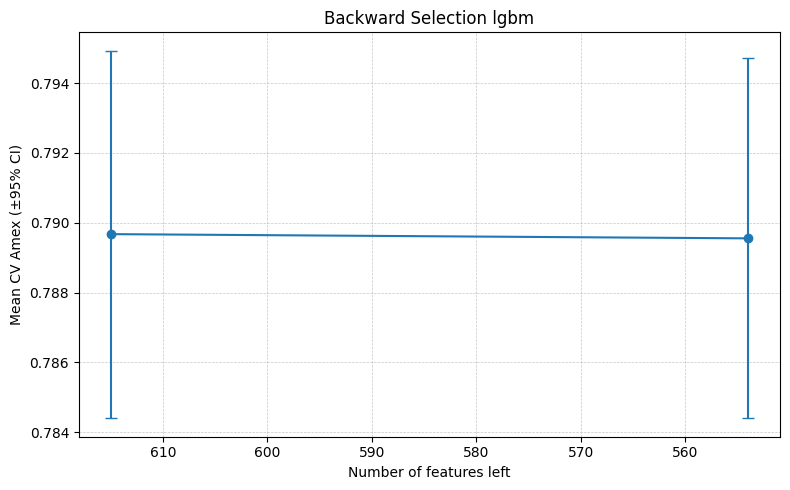

In [38]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

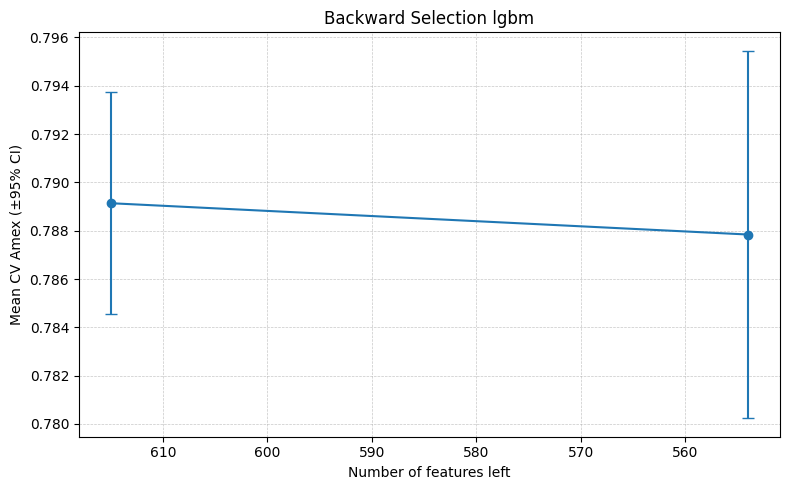

In [27]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection lgbm")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
test_preds

,iter_0,iter_1
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.046447,0.047620
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.001367,0.001422
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.046379,0.047366
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.334431,0.360902
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.889791,0.885847
...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,0.022109,0.021863
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,0.816386,0.836843
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.509889,0.494049


In [13]:
log_df, list_imp_dfs, remaining, test_preds = run_backward_selection(
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    num_feats=num_features,
    cat_feats=cat_features,
    group_col='customer_ID',
    min_feats=500
)


=== Step 0 | feats 615 (num 604, cat 11) | depth 6 trees 350
Fold 0
 Amex = 0.78721
Fold 1
 Amex = 0.79089
Fold 2
 Amex = 0.78931
Mean CV Amex: 0.78914 ± 0.00151

=== Step 1 | feats 554 (num 545, cat 9) | depth 6 trees 350
Fold 0
 Amex = 0.78501
Fold 1
 Amex = 0.79109
Fold 2
 Amex = 0.78742
Mean CV Amex: 0.78784 ± 0.00250


In [ ]:
def run_backward_selection(df_train,
                           df_test,
                           target_col,
                           num_feats,
                           cat_feats,
                           group_col,
                           min_feats: int = 10,
                           random_state: int = 42):

    num, cat = num_feats.copy(), cat_feats.copy()
    history, list_imp_dfs,  step = [], [], 0
    sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)
    test_preds_df = pd.DataFrame(index=df_test.customer_ID)  # accumulate test scores

    def n_to_drop(n):
        if n > 250: return max(1, int(n*.10))
        if n > 100: return max(1, int(n*.05))
        if n >  30: return max(1, int(n*.02))
        return 1

    def choose_params(n):
        if n > 250: return 6, 350
        if n > 100: return 5, 300
        if n >  50: return 3, 300
        if n >  10: return 2, 250
        return        2, 250

    y = df_train[target_col].values
    groups = df_train[group_col].values

    while True:
        feats = num + cat
        if len(feats) <= min_feats:
            break
        step += 1

        max_depth, n_estimators = choose_params(len(feats))
        params = dict(
            learning_rate=.05,
            subsample=.9, subsample_freq=1,
            colsample_bytree=.8,
            objective='binary',
            random_state=random_state,
            max_depth=max_depth,
            n_estimators=n_estimators,
            n_jobs=-1, # чтобы использовать все ядра CPU
            verbosity=-1
        )

        fold_scores, fold_test_raw = [], []

        print(f"\n=== Step {step} | features {len(feats)} "
              f"(num {len(num)}, cat {len(cat)}) | depth {max_depth} trees {n_estimators}")
        print()
        
        for fold, (tr_idx, va_idx) in enumerate(
                sgkf.split(X=df_train[[group_col, target_col]], y=y, groups=groups)):
            
            print(f"Fold {fold}")
            X_tr, X_va = df_train.iloc[tr_idx][feats], df_train.iloc[va_idx][feats]
            y_tr, y_va = y[tr_idx], y[va_idx]

            model = LGBMClassifier(**params)
            model.fit(X_tr, y_tr,
                      eval_set=[(X_va, y_va)],
                      eval_metric=lgb_amex_metric,
                      categorical_feature=cat)

            y_va_pred = model.predict_proba(X_va)[:,1]
            score = get_amex_metric_calculated(y_va, y_va_pred)
            fold_scores.append(score)

            # predict test at each Fold
            fold_test_raw.append(model.predict_proba(df_test[feats], raw_score=True))

            print(f"  Amex = {score:.5f}")

        mean_cv = float(np.mean(fold_scores))
        ci = stats.t.interval(.95, len(fold_scores)-1,
                              loc=mean_cv, scale=stats.sem(fold_scores))
        #print(f"Mean CV Amex = {mean_cv:.5f}  CI95 = [{ci[0]:.5f}, {ci[1]:.5f}]")
        print(f"\nMean CV Amex: {mean_cv:.5f} ± {np.std(fold_scores):.5f}")
        
        # store mean test prediction for this iteration
        test_preds_df[f'iter_{step}'] = np.mean(fold_test_raw, axis=0)

        # importance (gain)
        model_full = LGBMClassifier(**params).fit(
            df_train[feats], df_train[target_col], categorical_feature=cat)

        gains = model_full.booster_.feature_importance('gain')
        # тех. долг: по идее нужно делать list_imp_dfs.append(imp_df), который задаётся снизу
        #            однако мне хотелось сохранить без фильтра на gain > 0 и в порядке descending
        #            , а для drop_list нужен обратный порядок и фильтр на gain > 0.
        #            В общем не так красиво написал, как хотелосъ бы

        df_tmp = (
            pd.DataFrame({'feature': feats, 'gain': gains})
              .sort_values('gain', ascending=False)
        )
        df_tmp['share'] = df_tmp['gain'] / df_tmp['gain'].sum()
        list_imp_dfs.append(df_tmp)

        # importance (gain)
        imp_df = (pd.DataFrame({'feature': feats, 'gain': gains})
                    .query('gain > 0')               # keep only informative
                    .sort_values('gain', ascending=True))   # lowest first

        imp_df['share'] = imp_df['gain'] / imp_df['gain'].sum()

        k = n_to_drop(len(feats))
        drop_list = imp_df.head(k)['feature'].tolist()      # drop least‑important features     

        # print("Drop:", drop_list[:5], "..." if len(drop_list)>5 else "")

        num = [f for f in num if f not in drop_list]
        cat = [f for f in cat if f not in drop_list]

        history.append({
            'step': step,
            'n_feats_left': len(feats),
            'n_num_left': len(num),
            'n_cat_left': len(cat),
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'cv_mean': mean_cv,
            'cv_ci_lo': ci[0], 'cv_ci_hi': ci[1],
            # 'imp_df': imp_df,
            # 'dropped': drop_list
        })

    # final model
    md_final, ne_final = choose_params(len(num+cat))
    final_model = LGBMClassifier(
        learning_rate=.05, subsample=.9, subsample_freq=1,
        colsample_bytree=.8, objective='binary', random_state=random_state,
        max_depth=md_final, n_estimators=ne_final, verbosity=-1
    ).fit(df_train[num+cat], df_train[target_col], categorical_feature=cat)

    return (pd.DataFrame(history), list_imp_dfs, {'num': num, 'cat': cat},
            final_model, test_preds_df)

In [24]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

KeyError: 'cv_ci_lo'

In [ ]:
'''
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
'''

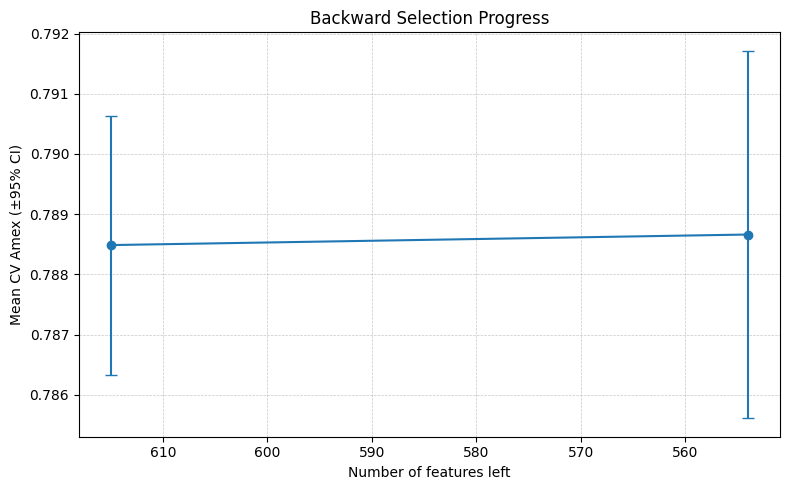

In [52]:
# Prepare data
plot_df = (log_df.sort_values('n_feats_left', ascending=False)
                   .reset_index(drop=True))

x = plot_df['n_feats_left']
y = plot_df['cv_mean']
yerr = [plot_df['cv_mean'] - plot_df['cv_ci_lo'],
        plot_df['cv_ci_hi'] - plot_df['cv_mean']]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4)
plt.gca().invert_xaxis()                 # high → low features left
plt.xlabel("Number of features left")
plt.ylabel("Mean CV Amex (±95% CI)")
plt.title("Backward Selection Progress")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [33]:
test_preds.head(3)

,iter_1,iter_2
customer_ID,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,-3.019499,-3.069418
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,-6.646071,-6.649168
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,-2.922014,-2.885177


In [35]:
log_df

,step,n_feats_left,n_num_left,n_cat_left,max_depth,n_estimators,cv_mean,cv_ci_lo,cv_ci_hi,dropped
0,1,615,545,9,6,350,0.788487,0.786336,0.790637,"[D_86_min, D_79_min, D_145_last, D_92_max, R_1..."
1,2,554,491,8,6,350,0.788662,0.785610,0.791714,"[R_4_max, S_19_last, D_81_min, D_83_min, D_93_..."


In [ ]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_preds.index,
                        'prediction': test_preds.iter_1.values})
    #sub.to_csv('submission_lgbm_backward_selection_test_preds_615_feats_test_wo_index.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.019499
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-6.646071
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.922014
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.681319
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.977357
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.900490
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.433510
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.152213
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.543022


In [ ]:
test_preds.iter_1.values

array([-3.01949949, -6.64607068, -2.92201373, ...,  0.15221332,
       -0.54302249, -2.4237113 ], shape=(924621,))

### LR & WoE & binning